In [1]:
import netCDF4 as nc
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy
from scipy.spatial.distance import cdist
from statsmodels.stats.multitest import multipletests
import tqdm
import matplotlib.colors as mcolors
from helpers import process_h as helper
from helpers import visualize_h as vis_helper
import skill_metrics as sm
import pysteps
import pandas as pd

Pysteps configuration file found at: /root/.pyenv/versions/3.10.11/envs/dsproj/lib/python3.10/site-packages/pysteps/pystepsrc



In [2]:
data_relative_path = os.path.join('..', 'Data')
precipitation_path = os.path.join(data_relative_path,'CMIP6','Precipitation')
WTIO_path = os.path.join(data_relative_path,'CMIP6','WTIO')
SEIO_path = os.path.join(data_relative_path,'CMIP6','SEIO')
CHIRPS_path = os.path.join(data_relative_path,'CHIRPS2')
SLP_path = os.path.join(data_relative_path,'CMIP6','SLP')
GPH500_path = os.path.join(data_relative_path,'CMIP6', 'GPH500')
ERA5_path = os.path.join(data_relative_path, 'ERA5')

In [3]:
dmi_baseline = scipy.io.loadmat(f"{data_relative_path}/DMI/DMI.mat")['DMI_Oct_1981_2022'][:, 1][:30]

In [4]:
precip_baseline = ((nc.Dataset(f"{CHIRPS_path}/CHIRPS_Monthly_precipitation.nc")['precip'][:])[9::12, 280:360, 800:920])[:30, :, :]

In [5]:
gph500_baseline = np.squeeze((nc.Dataset(f"{ERA5_path}/GPH500_ERA5.nc"))['z'][:], axis=1)

In [6]:
mslp_baseline = (nc.Dataset(f"{ERA5_path}/MSLP_ERA5.nc"))['msl'][:] / 100

In [7]:
# Converting units needed for converting models precipitation measurements
unit_conversion = 86400 * 31
# Map latitude and longitude boundaries
bounds_middle_east_lat = [20, 40]
bounds_middle_east_lon = [20, 50]
boundaries_middle_east = bounds_middle_east_lon + bounds_middle_east_lat
bounds_general_lat = [-20, 50]
bounds_general_lon = [-10, 110]
boundaries_general = bounds_general_lon + bounds_general_lat
# A dimension we want our grid to have
dim = (16, 16)
chirps_dim = precip_baseline.shape[1], precip_baseline.shape[2]
era5_dim = gph500_baseline.shape[1], gph500_baseline.shape[2]

First we need to load the data.

In [8]:
wtio = helper.collect_all_datasets(WTIO_path, 'wtio')
seio = helper.collect_all_datasets(SEIO_path, 'seio')

 21%|█████████████████▌                                                                  | 5/24 [00:00<00:00, 49.87it/s]

tos_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
tos_Omon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc
tos_Omon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc
tos_Omon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc
tos_Omon_CNRM-CM6-1-HR_historical_r1i1p1f2_gn_19811016-20101016_v20191021.nc
tos_Omon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190826.nc
tos_Omon_EC-Earth3-AerChem_historical_r1i1p1f1_gn_19811016-20101016_v20200624.nc


 71%|██████████████████████████████████████████████████████████▊                        | 17/24 [00:00<00:00, 45.16it/s]

tos_Omon_FGOALS-f3-L_historical_r1i1p1f1_gn_19811016-20101016_v20191007.nc
tos_Omon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191122.nc
tos_Omon_GFDL-ESM4_historical_r1i1p1f1_gr_19811016-20101016_v20190726.nc
tos_Omon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc
tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc
tos_Omon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20200915.nc
tos_Omon_INM-CM5-0_historical_r1i1p1f1_gr1_19811016-20101016_v20190610.nc
tos_Omon_IPSL-CM6A-LR_historical_r1i1p1f1_gn_19811016-20101016_v20180803.nc
tos_Omon_MCM-UA-1-0_historical_r0i0p0f2_gn_19811017-20101017_v20190731.nc
tos_Omon_MIROC6_historical_r1i1p1f1_gn_19811016-20101016_v20181212.nc
tos_Omon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19811016-20101016_v20190710.nc
tos_Omon_MRI-ESM2-0_historical_r1i1p1f1_gr_19811016-20101016_v20190904.nc


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 41.46it/s]


tos_Omon_NESM3_historical_r1i1p1f1_gn_19811016-20101016_v20190703.nc
tos_Omon_NorESM2-MM_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
tos_Omon_SAM0-UNICON_historical_r1i1p1f1_gn_19811016-20101016_v20190323.nc
tos_Omon_TaiESM1_historical_r1i1p1f1_gn_19811016-20101016_v20200630.nc
tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_19811016-20101016_v20190627.nc


  0%|                                                                                            | 0/24 [00:00<?, ?it/s]

tos_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
tos_Omon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc
tos_Omon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc


 46%|██████████████████████████████████████                                             | 11/24 [00:00<00:00, 52.71it/s]

tos_Omon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc
tos_Omon_CNRM-CM6-1-HR_historical_r1i1p1f2_gn_19811016-20101016_v20191021.nc
tos_Omon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190826.nc
tos_Omon_EC-Earth3-AerChem_historical_r1i1p1f1_gn_19811016-20101016_v20200624.nc
tos_Omon_FGOALS-f3-L_historical_r1i1p1f1_gn_19811016-20101016_v20191007.nc
tos_Omon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191122.nc
tos_Omon_GFDL-ESM4_historical_r1i1p1f1_gr_19811016-20101016_v20190726.nc
tos_Omon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc
tos_Omon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc
tos_Omon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20200915.nc
tos_Omon_INM-CM5-0_historical_r1i1p1f1_gr1_19811016-20101016_v20190610.nc
tos_Omon_IPSL-CM6A-LR_historical_r1i1p1f1_gn_19811016-20101016_v20180803.nc


 71%|██████████████████████████████████████████████████████████▊                        | 17/24 [00:00<00:00, 53.61it/s]

tos_Omon_MCM-UA-1-0_historical_r0i0p0f2_gn_19811017-20101017_v20190731.nc
tos_Omon_MIROC6_historical_r1i1p1f1_gn_19811016-20101016_v20181212.nc
tos_Omon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19811016-20101016_v20190710.nc
tos_Omon_MRI-ESM2-0_historical_r1i1p1f1_gr_19811016-20101016_v20190904.nc
tos_Omon_NESM3_historical_r1i1p1f1_gn_19811016-20101016_v20190703.nc
tos_Omon_NorESM2-MM_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 49.88it/s]

tos_Omon_SAM0-UNICON_historical_r1i1p1f1_gn_19811016-20101016_v20190323.nc
tos_Omon_TaiESM1_historical_r1i1p1f1_gn_19811016-20101016_v20200630.nc
tos_Omon_UKESM1-0-LL_historical_r1i1p1f2_gn_19811016-20101016_v20190627.nc


In [9]:
options = {"interpolate": True,
           "force grid": False,
           "average": False}

In [10]:
precip  = helper.collect_all_datasets(precipitation_path, 'precip', chirps_dim, unit_conversion, bounds_middle_east_lat, bounds_middle_east_lon, options)

  0%|                                                                                            | 0/24 [00:00<?, ?it/s]

pr_Amon_ACCESS-CM2_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
(30, 16, 16)


  4%|███▌                                                                                | 1/24 [00:00<00:08,  2.64it/s]

pr_Amon_CAMS-CSM1-0_historical_r1i1p1f1_gn_19811016-20101016_v20190708.nc
(30, 18, 27)


  8%|███████                                                                             | 2/24 [00:00<00:08,  2.51it/s]

pr_Amon_CanESM5-CanOE_historical_r1i1p2f1_gn_19811016-20101016_v20190429.nc
(30, 7, 10)


 12%|██████████▌                                                                         | 3/24 [00:01<00:07,  2.66it/s]

pr_Amon_CMCC-CM2-HR4_historical_r1i1p1f1_gn_19811016-20101016_v20200904.nc
(30, 21, 25)


 17%|██████████████                                                                      | 4/24 [00:01<00:07,  2.67it/s]

pr_Amon_CNRM-CM6-1-HR_historical_r1i1p1f2_gr_19811016-20101016_v20191021.nc
(30, 40, 61)


 21%|█████████████████▌                                                                  | 5/24 [00:02<00:08,  2.33it/s]

pr_Amon_E3SM-1-0_historical_r1i1p1f1_gr_19811016-20101016_v20190913.nc
(30, 20, 30)


 25%|█████████████████████                                                               | 6/24 [00:02<00:07,  2.43it/s]

pr_Amon_EC-Earth3-AerChem_historical_r1i1p1f1_gr_19811016-20101016_v20200624.nc
(30, 28, 43)


 29%|████████████████████████▌                                                           | 7/24 [00:02<00:07,  2.42it/s]

pr_Amon_FGOALS-f3-L_historical_r1i1p1f1_gr_19811016-20101016_v20190927.nc
(30, 20, 24)


 33%|████████████████████████████                                                        | 8/24 [00:03<00:06,  2.50it/s]

pr_Amon_FIO-ESM-2-0_historical_r1i1p1f1_gn_19811016-20101016_v20191209.nc
(30, 21, 25)


 38%|███████████████████████████████▌                                                    | 9/24 [00:03<00:05,  2.54it/s]

pr_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_19811016-20101016_v20190726.nc
(30, 20, 24)


 42%|██████████████████████████████████▌                                                | 10/24 [00:03<00:05,  2.58it/s]

pr_Amon_GISS-E2-1-H_historical_r1i1p1f1_gn_19811016-20101016_v20190403.nc
(30, 10, 12)


 46%|██████████████████████████████████████                                             | 11/24 [00:04<00:04,  2.70it/s]

pr_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19811016-20101016_v20190624.nc
(30, 16, 16)


 50%|█████████████████████████████████████████▌                                         | 12/24 [00:04<00:04,  2.73it/s]

pr_Amon_IITM-ESM_historical_r1i1p1f1_gn_19811016-20101016_v20191226.nc
(30, 10, 16)


 54%|████████████████████████████████████████████▉                                      | 13/24 [00:04<00:03,  2.77it/s]

pr_Amon_INM-CM5-0_historical_r1i1p1f1_gr1_19811016-20101016_v20190610.nc
(30, 14, 16)


 58%|████████████████████████████████████████████████▍                                  | 14/24 [00:05<00:03,  2.81it/s]

pr_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19811016-20101016_v20180803.nc
(30, 16, 13)


 62%|███████████████████████████████████████████████████▉                               | 15/24 [00:05<00:03,  2.81it/s]

pr_Amon_MCM-UA-1-0_historical_r1i1p1f2_gn_19811017-20101017_v20191017.nc
(30, 9, 8)


 67%|███████████████████████████████████████████████████████▎                           | 16/24 [00:06<00:02,  2.86it/s]

pr_Amon_MIROC6_historical_r1i1p1f1_gn_19811016-20101016_v20181212.nc
(30, 15, 21)


 71%|██████████████████████████████████████████████████████████▊                        | 17/24 [00:06<00:02,  2.85it/s]

pr_Amon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_19811016-20101016_v20190710.nc
(30, 22, 32)


 75%|██████████████████████████████████████████████████████████████▎                    | 18/24 [00:06<00:02,  2.73it/s]

pr_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_19811016-20101016_v20190222.nc
(30, 18, 27)


 79%|█████████████████████████████████████████████████████████████████▋                 | 19/24 [00:07<00:01,  2.72it/s]

pr_Amon_NESM3_historical_r1i1p1f1_gn_19811016-20101016_v20190630.nc
(30, 10, 16)


 83%|█████████████████████████████████████████████████████████████████████▏             | 20/24 [00:07<00:01,  2.78it/s]

pr_Amon_NorESM2-MM_historical_r1i1p1f1_gn_19811016-20101016_v20191108.nc
(30, 21, 25)


 88%|████████████████████████████████████████████████████████████████████████▋          | 21/24 [00:07<00:01,  2.71it/s]

pr_Amon_SAM0-UNICON_historical_r1i1p1f1_gn_19811016-20101016_v20190323.nc
(30, 21, 25)


 92%|████████████████████████████████████████████████████████████████████████████       | 22/24 [00:08<00:00,  2.69it/s]

pr_Amon_TaiESM1_historical_r1i1p1f1_gn_19811016-20101016_v20200623.nc
(30, 21, 25)


 96%|███████████████████████████████████████████████████████████████████████████████▌   | 23/24 [00:08<00:00,  2.65it/s]

pr_Amon_UKESM1-0-LL_historical_r1i1p1f2_gn_19811016-20101016_v20190406.nc
(30, 16, 16)


100%|███████████████████████████████████████████████████████████████████████████████████| 24/24 [00:09<00:00,  2.66it/s]


In [11]:
lats, lons = {key: val[1] for key, val in precip.items()}, {key: val[2] for key, val in precip.items()}
precip = {key: val[0] for key, val in precip.items()}

In [12]:
masked_precip = {key: np.ma.array(val, mask=precip_baseline.mask) for key, val in precip.items()}

In [13]:
dmi = helper.calc_dmi(wtio, seio, 'anomaly grid - mean first')

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 100.61it/s]


In [14]:
corrs = dict()

for key in tqdm.tqdm(masked_precip.keys()):
    corr_mat = helper.calc_dmi_precp_corr_vec(dmi[key], masked_precip[key])
    corrs[key] = corr_mat

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 104.32it/s]


In [15]:
alpha = 0.05
tested_corrs = {key: np.where(helper.calc_corr_t_test(corr_map) > alpha, 0, corr_map) for key, corr_map in corrs.items()}

In [16]:
def correct_pvals(pvals, method):
    return multipletests(pvals, alpha=alpha, method=method)[1]
corrected_corrs_bonferroni = {}
corrected_corrs_fdr = {}

for key, corr_map in corrs.items():
    pvals = helper.calc_corr_t_test(corr_map).flatten()

    bonferroni_pvals = correct_pvals(pvals, method='bonferroni')
    bonferroni_corr_map = np.where(bonferroni_pvals.reshape(corr_map.shape) > alpha, 0, corr_map)
    corrected_corrs_bonferroni[key] = bonferroni_corr_map

    fdr_pvals = correct_pvals(pvals, method='fdr_bh')
    fdr_corr_map = np.where(fdr_pvals.reshape(corr_map.shape) > alpha, 0, corr_map)
    corrected_corrs_fdr[key] = fdr_corr_map


In [17]:
corr_baseline = helper.calc_dmi_precp_corr_vec(dmi_baseline, precip_baseline)
tested_corr_baseline = np.where(helper.calc_corr_t_test(corr_baseline) > alpha, 0, corr_baseline)

In [18]:
pvals_baseline = helper.calc_corr_t_test(corr_baseline).flatten()
bonferroni_pvals_baseline = correct_pvals(pvals_baseline, method='bonferroni')
tested_corr_baseline_bonferroni = np.where(bonferroni_pvals_baseline.reshape(corr_baseline.shape) > alpha, 0, corr_baseline)
fdr_pvals_baseline = correct_pvals(pvals_baseline, method='fdr_bh')
tested_corr_baseline_fdr = np.where(fdr_pvals_baseline.reshape(corr_baseline.shape) > alpha, 0, corr_baseline)

# With T-test

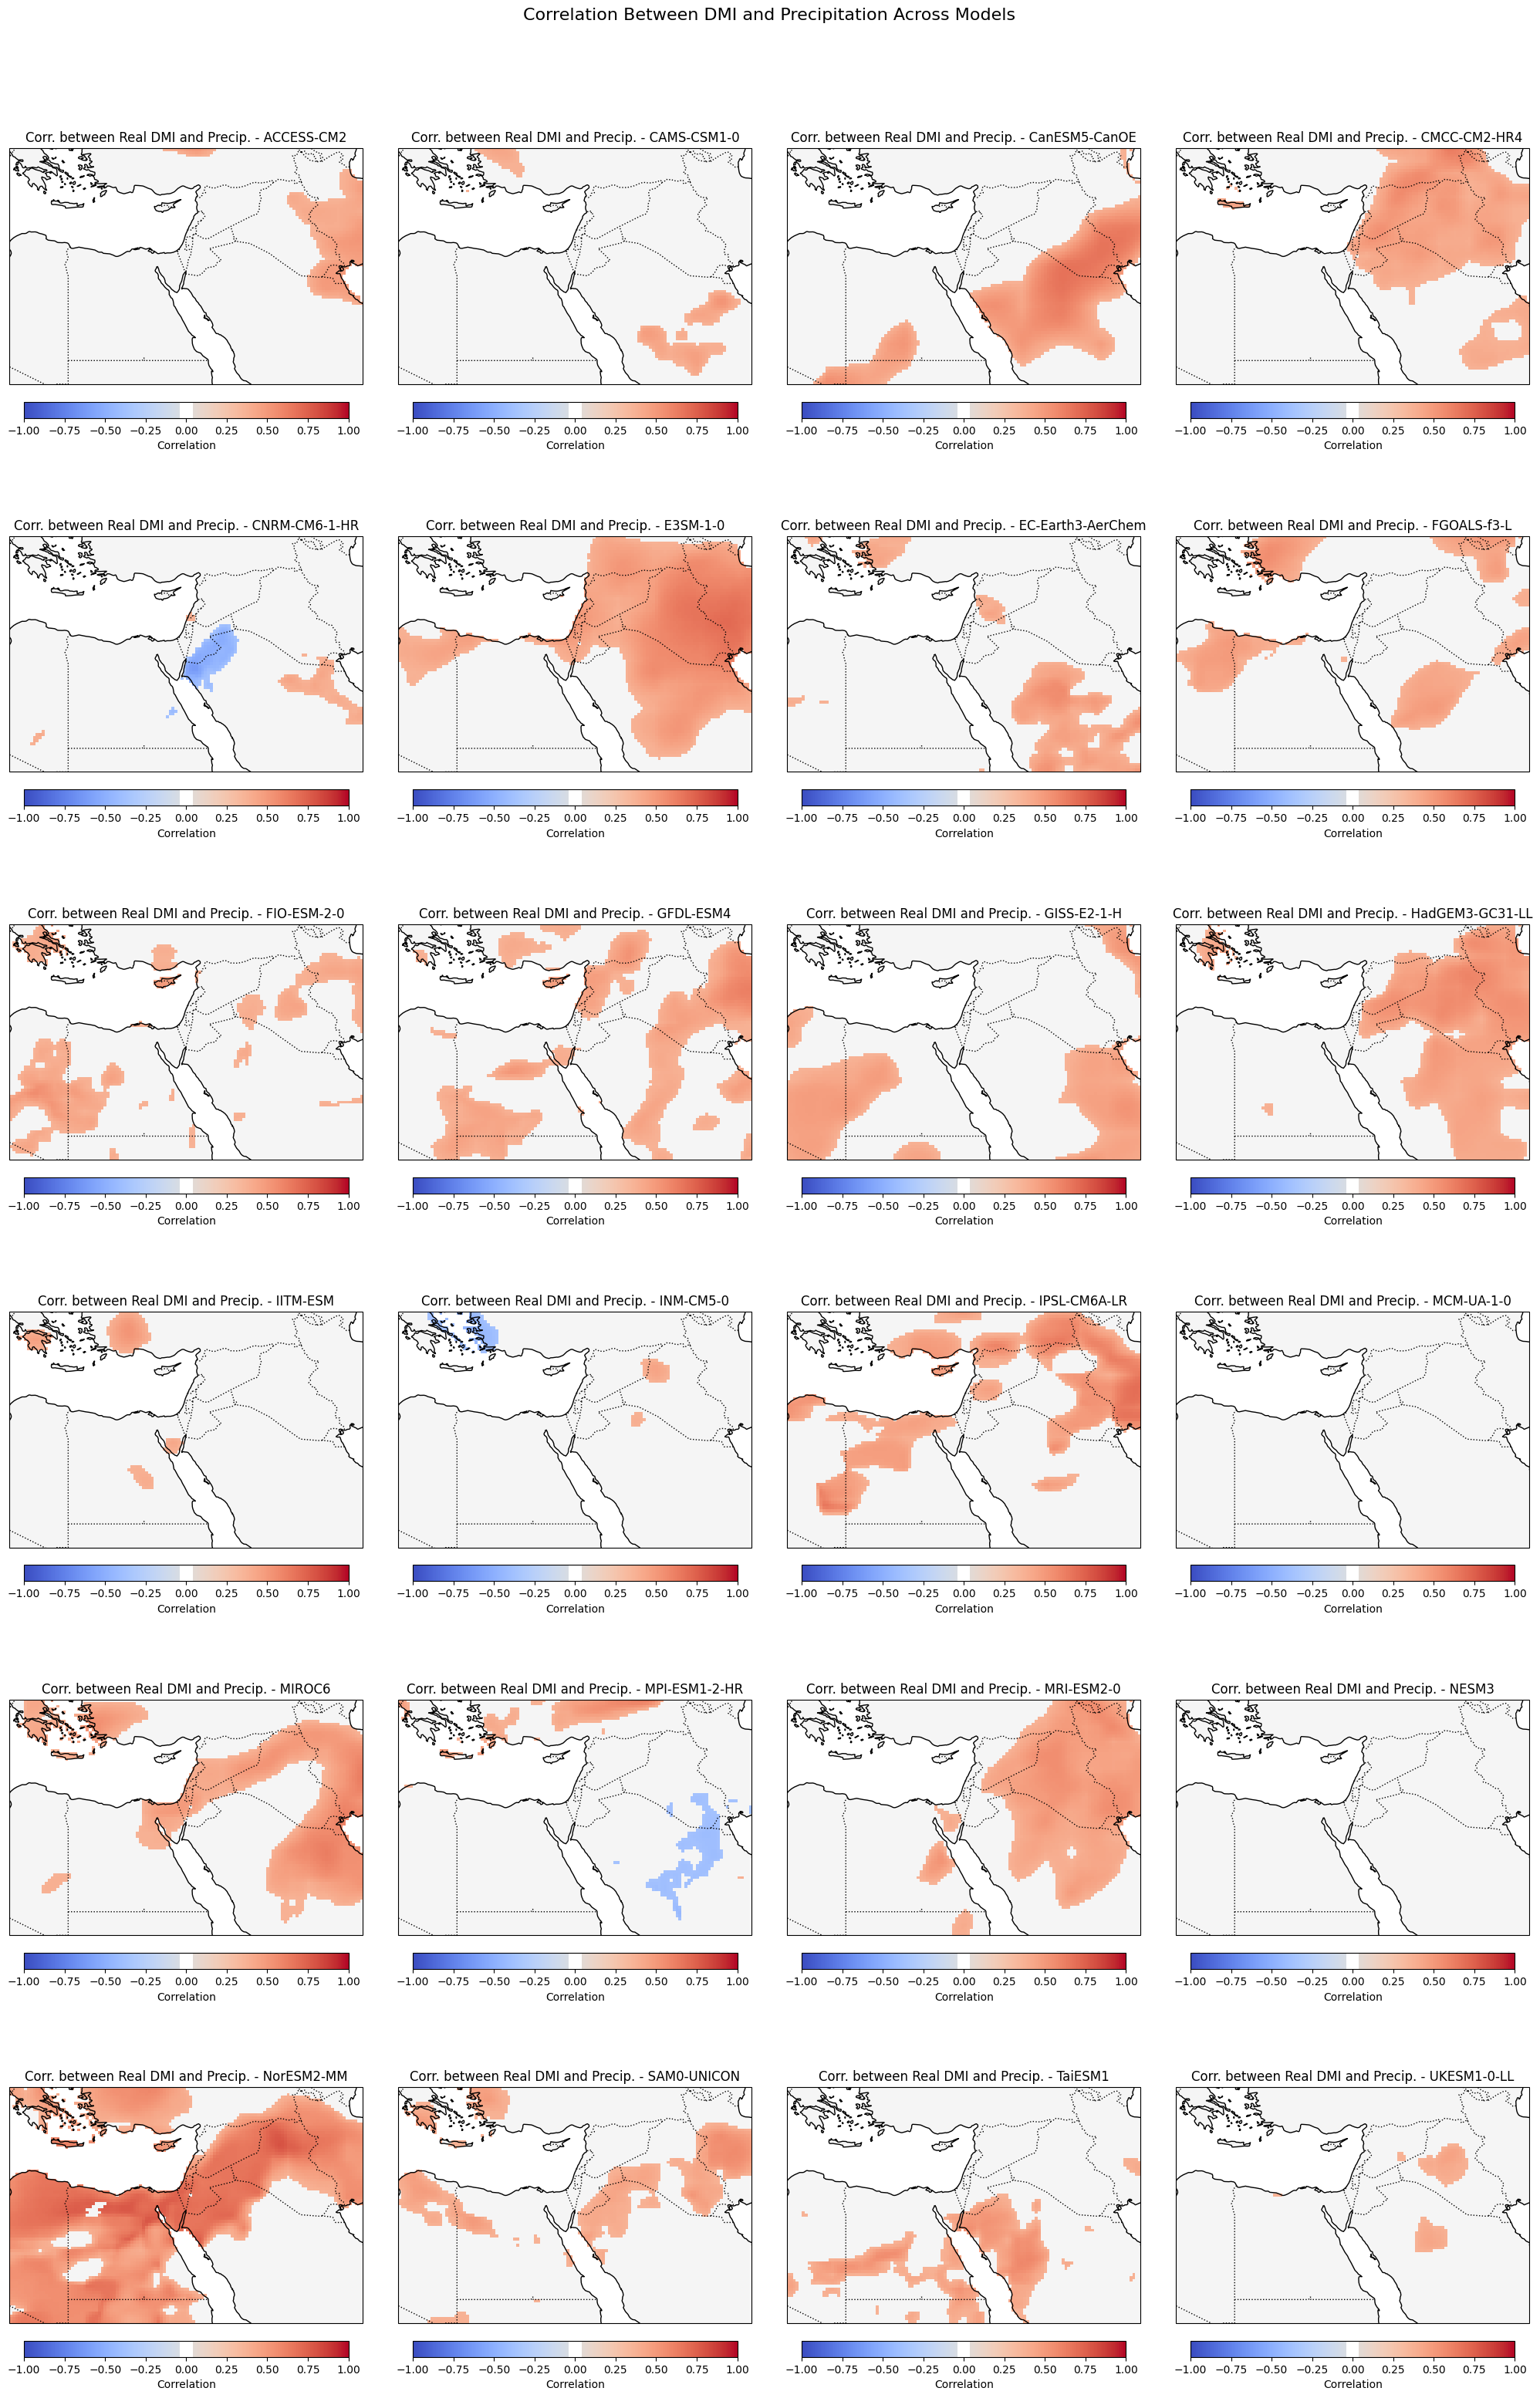

In [19]:
fig, axes = plt.subplots(6, 4, figsize=(20, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
mats = list(tested_corrs.values())
titles = list(tested_corrs.keys())


for i, (ax, key, value) in enumerate(zip(axes.ravel(), titles, mats)):
    vis_helper.plot_corr_heatmap_rigid(ax, value, boundaries_middle_east, 'Correlation between DMI and Precipitation', f'Corr. between Real DMI and Precip. - {key}', 0)

fig.suptitle('Correlation Between DMI and Precipitation Across Models', fontsize=16, y=1.02)    
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

### FDR

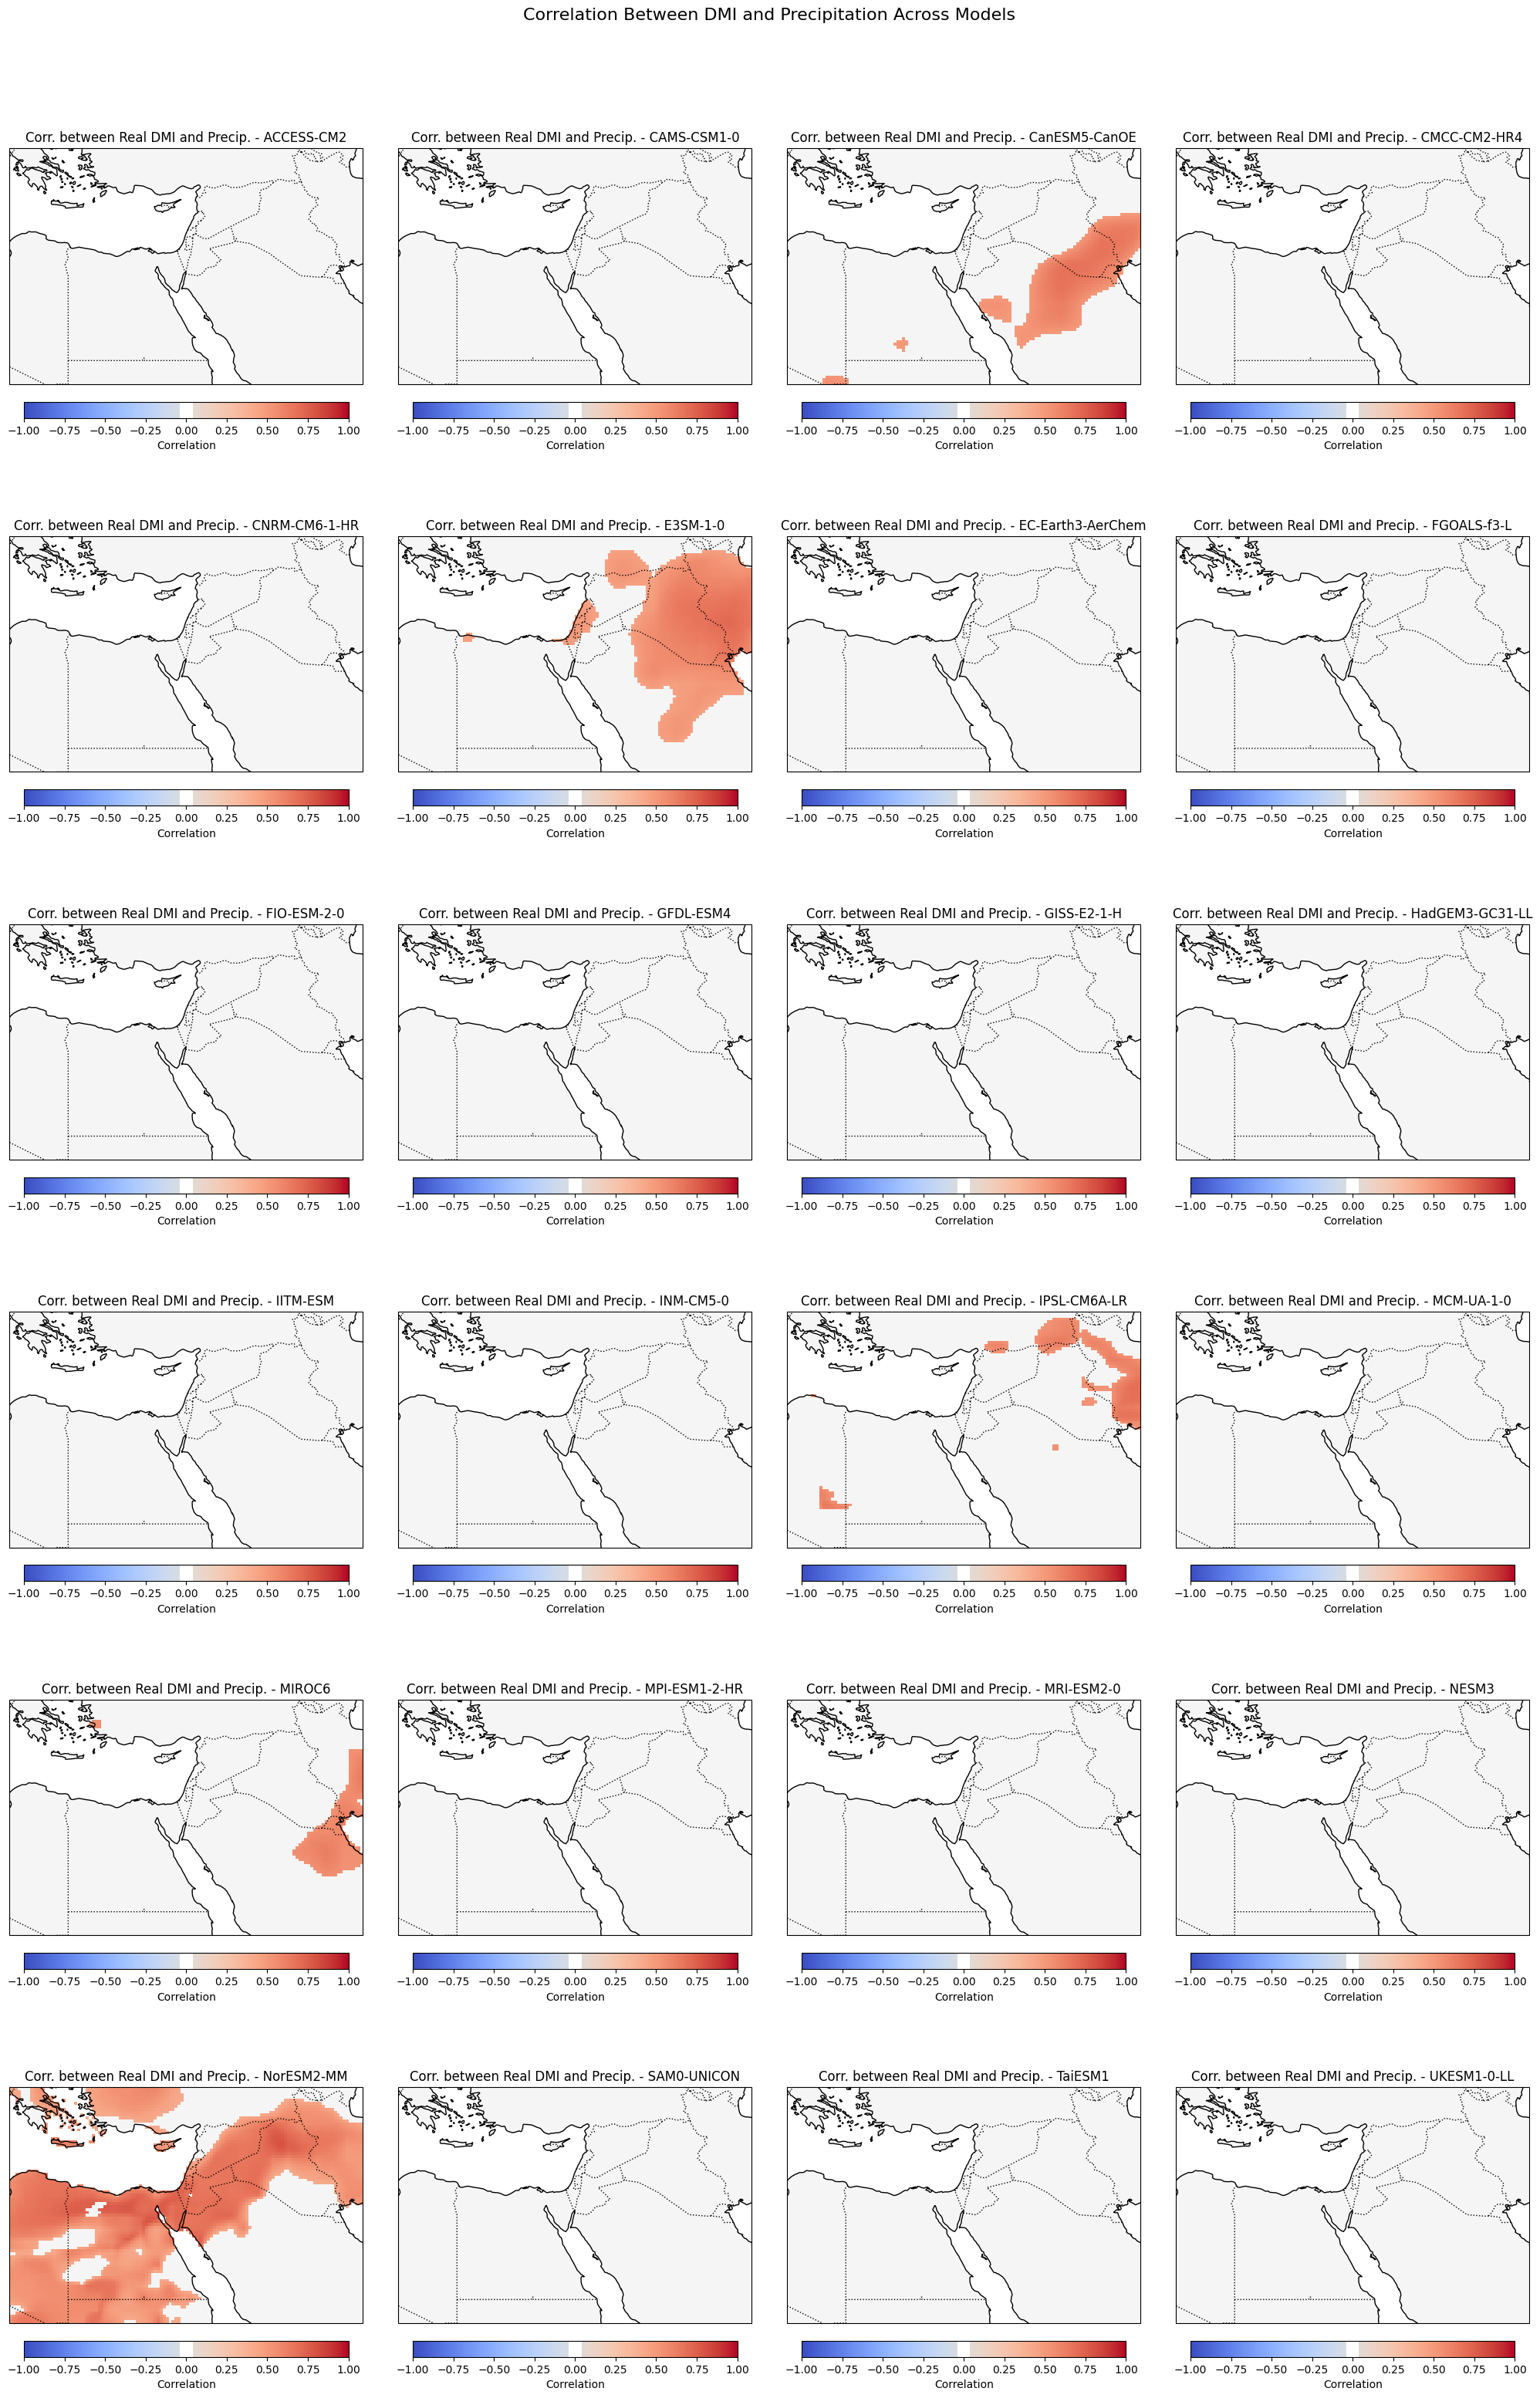

In [20]:
fig, axes = plt.subplots(6, 4, figsize=(20, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
mats = list(corrected_corrs_fdr.values())
titles = list(corrected_corrs_fdr.keys())


for i, (ax, key, value) in enumerate(zip(axes.ravel(), titles, mats)):
    vis_helper.plot_corr_heatmap_rigid(ax, value, boundaries_middle_east, 'Correlation between DMI and Precipitation', f'Corr. between Real DMI and Precip. - {key}', 0)

fig.suptitle('Correlation Between DMI and Precipitation Across Models', fontsize=16, y=1.02)    
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

lets look at the real correlation

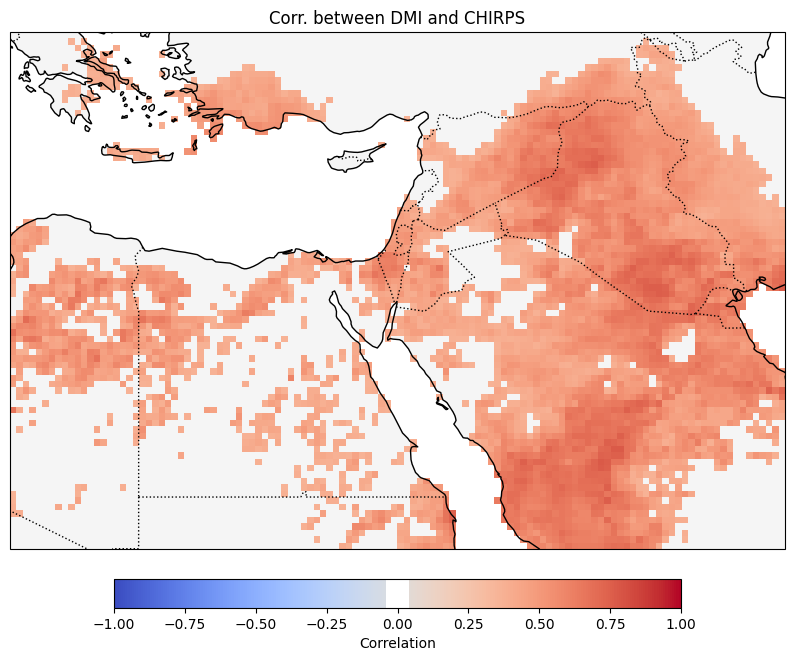

In [21]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vis_helper.plot_corr_heatmap_rigid(ax, tested_corr_baseline, boundaries_middle_east, 'Correlation between DMI and Precipitation', 'Corr. between DMI and CHIRPS', 0)


### Bonferroni

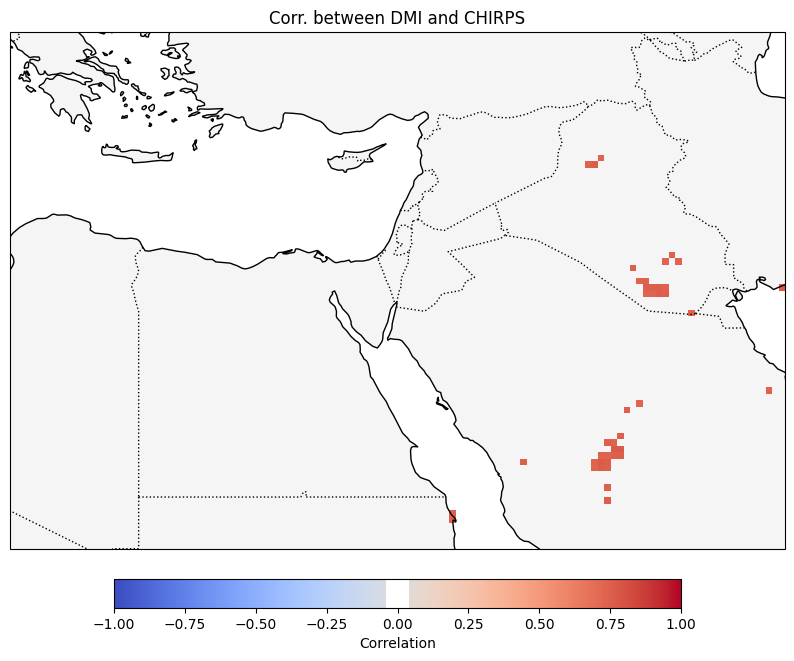

In [22]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vis_helper.plot_corr_heatmap_rigid(ax, tested_corr_baseline_bonferroni, boundaries_middle_east, 'Correlation between DMI and Precipitation', 'Corr. between DMI and CHIRPS', 0)


### FDR

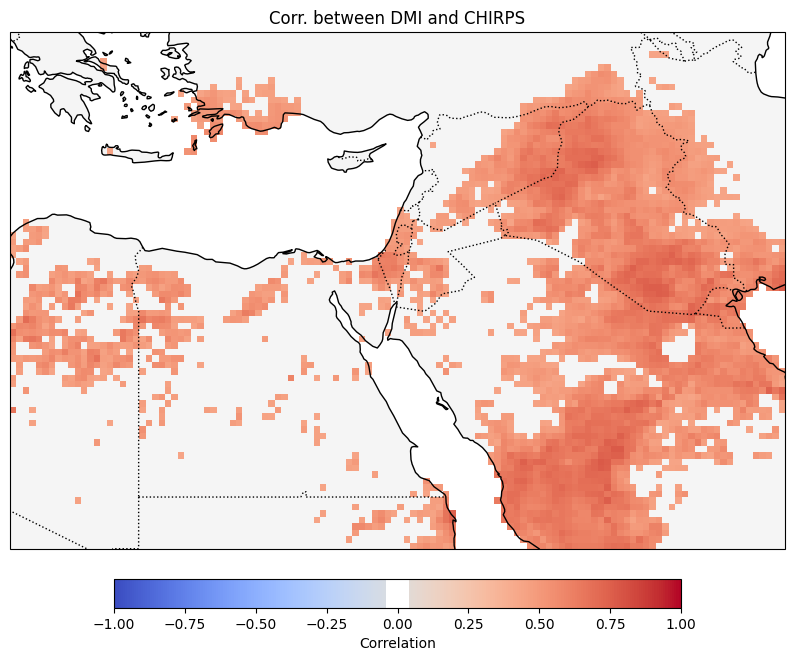

In [23]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vis_helper.plot_corr_heatmap_rigid(ax, tested_corr_baseline_fdr, boundaries_middle_east, 'Correlation between DMI and Precipitation', 'Corr. between DMI and CHIRPS', 0)


# Without T-Test

In [24]:
# fig, axes = plt.subplots(6, 4, figsize=(20, 30), subplot_kw={'projection': ccrs.PlateCarree()})
# fig.tight_layout()
# mats = list(corrs.values())
# titles = list(corrs.keys())


# for i, (ax, key, value) in enumerate(zip(axes.ravel(), titles, mats)):
#     vis_helper.plot_corr_heatmap_rigid(ax, value, boundaries_middle_east, 'Correlation between DMI and Precipitation', f'Corr. between Real DMI and Precip. - {key}', 0)
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
# plt.show()

Again, real correlation for comparison

In [25]:
# fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# vis_helper.plot_corr_heatmap_rigid(ax, corr_baseline, boundaries_middle_east, 'Correlation between DMI and Precipitation', 'Corr. between DMI and CHIRPS - Without t-test', 0)


In [26]:
avg_corrs = np.array([np.nanmean(corr_map) for key, corr_map in corrected_corrs_fdr.items()])

In [27]:
stds = np.array([np.nanstd(dmi_arr) for key, dmi_arr in dmi.items()])

In [28]:
baseline_sd = np.nanstd(dmi_baseline)

In [29]:
avg_corr_baseline = np.mean(tested_corr_baseline_fdr)

In [30]:
rmsds = []
for key, dmi_arr in dmi.items():
    rmsds.append(sm.centered_rms_dev(dmi_arr, dmi_baseline))
    
rmsds = np.array(rmsds)

In [31]:
labels = list(corrs.keys())

In [32]:
avg_corrs = np.array([avg_corr_baseline] + avg_corrs.tolist())
stds = np.array ([baseline_sd] + stds.tolist()) # [baseline_sd].extend(stds)
rmsds = np.array([0] + rmsds.tolist()) #[0].extend(rmsds)
labels = ['Baseline'] + labels

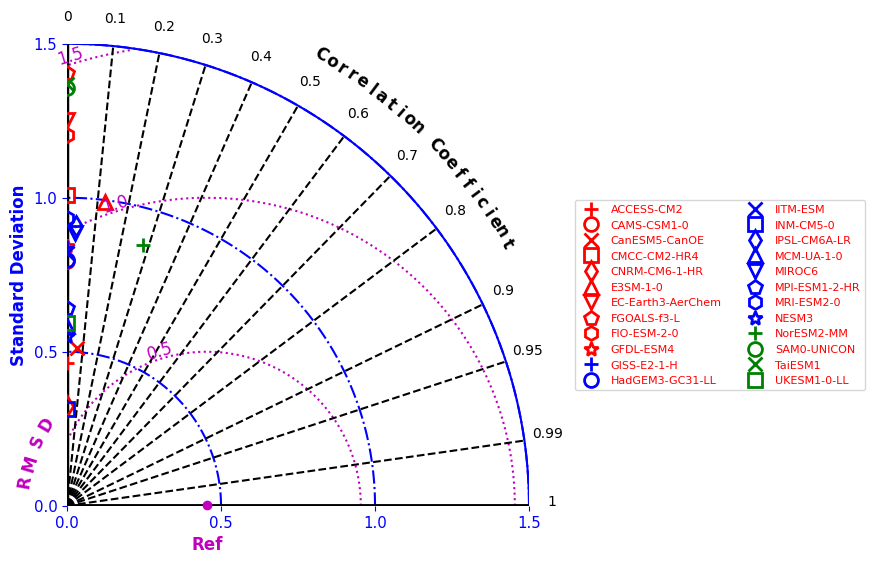

In [33]:
fig, ax = plt.subplots(figsize=(15, 6))
sm.taylor_diagram(stds, rmsds, avg_corrs, markerLabel = labels, markerLegend = 'on',
                  markerLabelColor = 'r', 
                  colRMS = 'm', styleRMS = ':', 
                  colSTD = 'b', styleSTD = '-.', 
                  colCOR = 'k', styleCOR = '--',
                 markerobs = 'o', titleOBS = 'Ref',
                  titleSTD ='on',
                 alpha = 0)

In [34]:
for i, key in enumerate(labels):
    print(f"AVG. Correlation in Model {key} - {round(avg_corrs[i], 2)}")

AVG. Correlation in Model Baseline - 0.17
AVG. Correlation in Model ACCESS-CM2 - 0.0
AVG. Correlation in Model CAMS-CSM1-0 - 0.0
AVG. Correlation in Model CanESM5-CanOE - 0.06
AVG. Correlation in Model CMCC-CM2-HR4 - 0.0
AVG. Correlation in Model CNRM-CM6-1-HR - 0.0
AVG. Correlation in Model E3SM-1-0 - 0.12
AVG. Correlation in Model EC-Earth3-AerChem - 0.0
AVG. Correlation in Model FGOALS-f3-L - 0.0
AVG. Correlation in Model FIO-ESM-2-0 - 0.0
AVG. Correlation in Model GFDL-ESM4 - 0.0
AVG. Correlation in Model GISS-E2-1-H - 0.0
AVG. Correlation in Model HadGEM3-GC31-LL - 0.0
AVG. Correlation in Model IITM-ESM - 0.0
AVG. Correlation in Model INM-CM5-0 - 0.0
AVG. Correlation in Model IPSL-CM6A-LR - 0.03
AVG. Correlation in Model MCM-UA-1-0 - 0.0
AVG. Correlation in Model MIROC6 - 0.03
AVG. Correlation in Model MPI-ESM1-2-HR - 0.0
AVG. Correlation in Model MRI-ESM2-0 - 0.0
AVG. Correlation in Model NESM3 - 0.0
AVG. Correlation in Model NorESM2-MM - 0.28
AVG. Correlation in Model SAM0-UNICO

In [35]:
max_corrs = np.array([np.nanmax(corr_map) for key, corr_map in corrected_corrs_fdr.items()])
max_corr_baseline = np.max(tested_corr_baseline_fdr)
max_corrs = np.array([max_corr_baseline] + max_corrs.tolist())


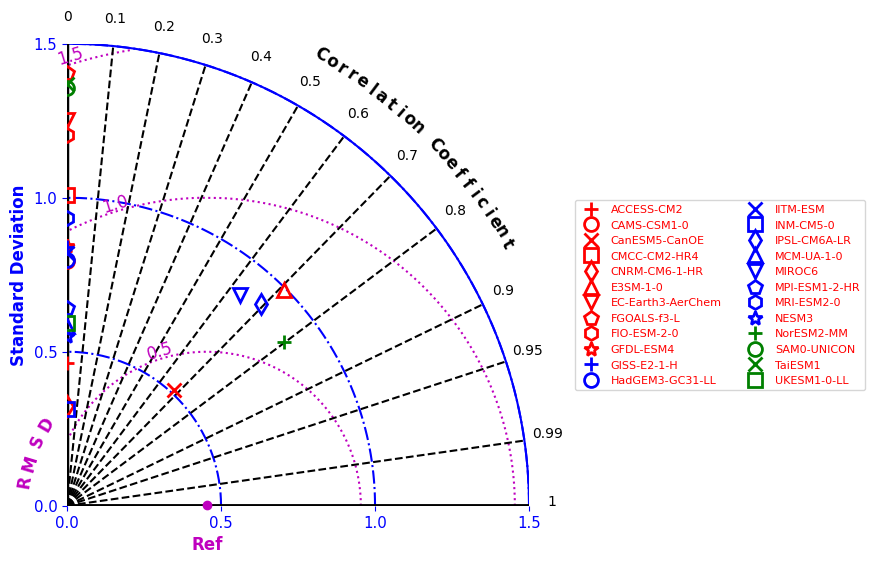

In [36]:
fig, ax = plt.subplots(figsize=(15, 6))
sm.taylor_diagram(stds, rmsds, max_corrs, markerLabel = labels, markerLegend = 'on',
                  markerLabelColor = 'r', 
                  colRMS = 'm', styleRMS = ':', 
                  colSTD = 'b', styleSTD = '-.', 
                  colCOR = 'k', styleCOR = '--',
                 markerobs = 'o', titleOBS = 'Ref',
                  titleSTD ='on',
                 alpha = 0)

In [37]:
for i, key in enumerate(labels):
    print(f"Max Correlation in Model {key} - {round(max_corrs[i], 2)}")

Max Correlation in Model Baseline - 0.77
Max Correlation in Model ACCESS-CM2 - 0.0
Max Correlation in Model CAMS-CSM1-0 - 0.0
Max Correlation in Model CanESM5-CanOE - 0.68
Max Correlation in Model CMCC-CM2-HR4 - 0.0
Max Correlation in Model CNRM-CM6-1-HR - 0.0
Max Correlation in Model E3SM-1-0 - 0.71
Max Correlation in Model EC-Earth3-AerChem - 0.0
Max Correlation in Model FGOALS-f3-L - 0.0
Max Correlation in Model FIO-ESM-2-0 - 0.0
Max Correlation in Model GFDL-ESM4 - 0.0
Max Correlation in Model GISS-E2-1-H - 0.0
Max Correlation in Model HadGEM3-GC31-LL - 0.0
Max Correlation in Model IITM-ESM - 0.0
Max Correlation in Model INM-CM5-0 - 0.0
Max Correlation in Model IPSL-CM6A-LR - 0.69
Max Correlation in Model MCM-UA-1-0 - 0.0
Max Correlation in Model MIROC6 - 0.63
Max Correlation in Model MPI-ESM1-2-HR - 0.0
Max Correlation in Model MRI-ESM2-0 - 0.0
Max Correlation in Model NESM3 - 0.0
Max Correlation in Model NorESM2-MM - 0.8
Max Correlation in Model SAM0-UNICON - 0.0
Max Correlation 

Lets look at the correlation diffs to see how they compare to the baseline.

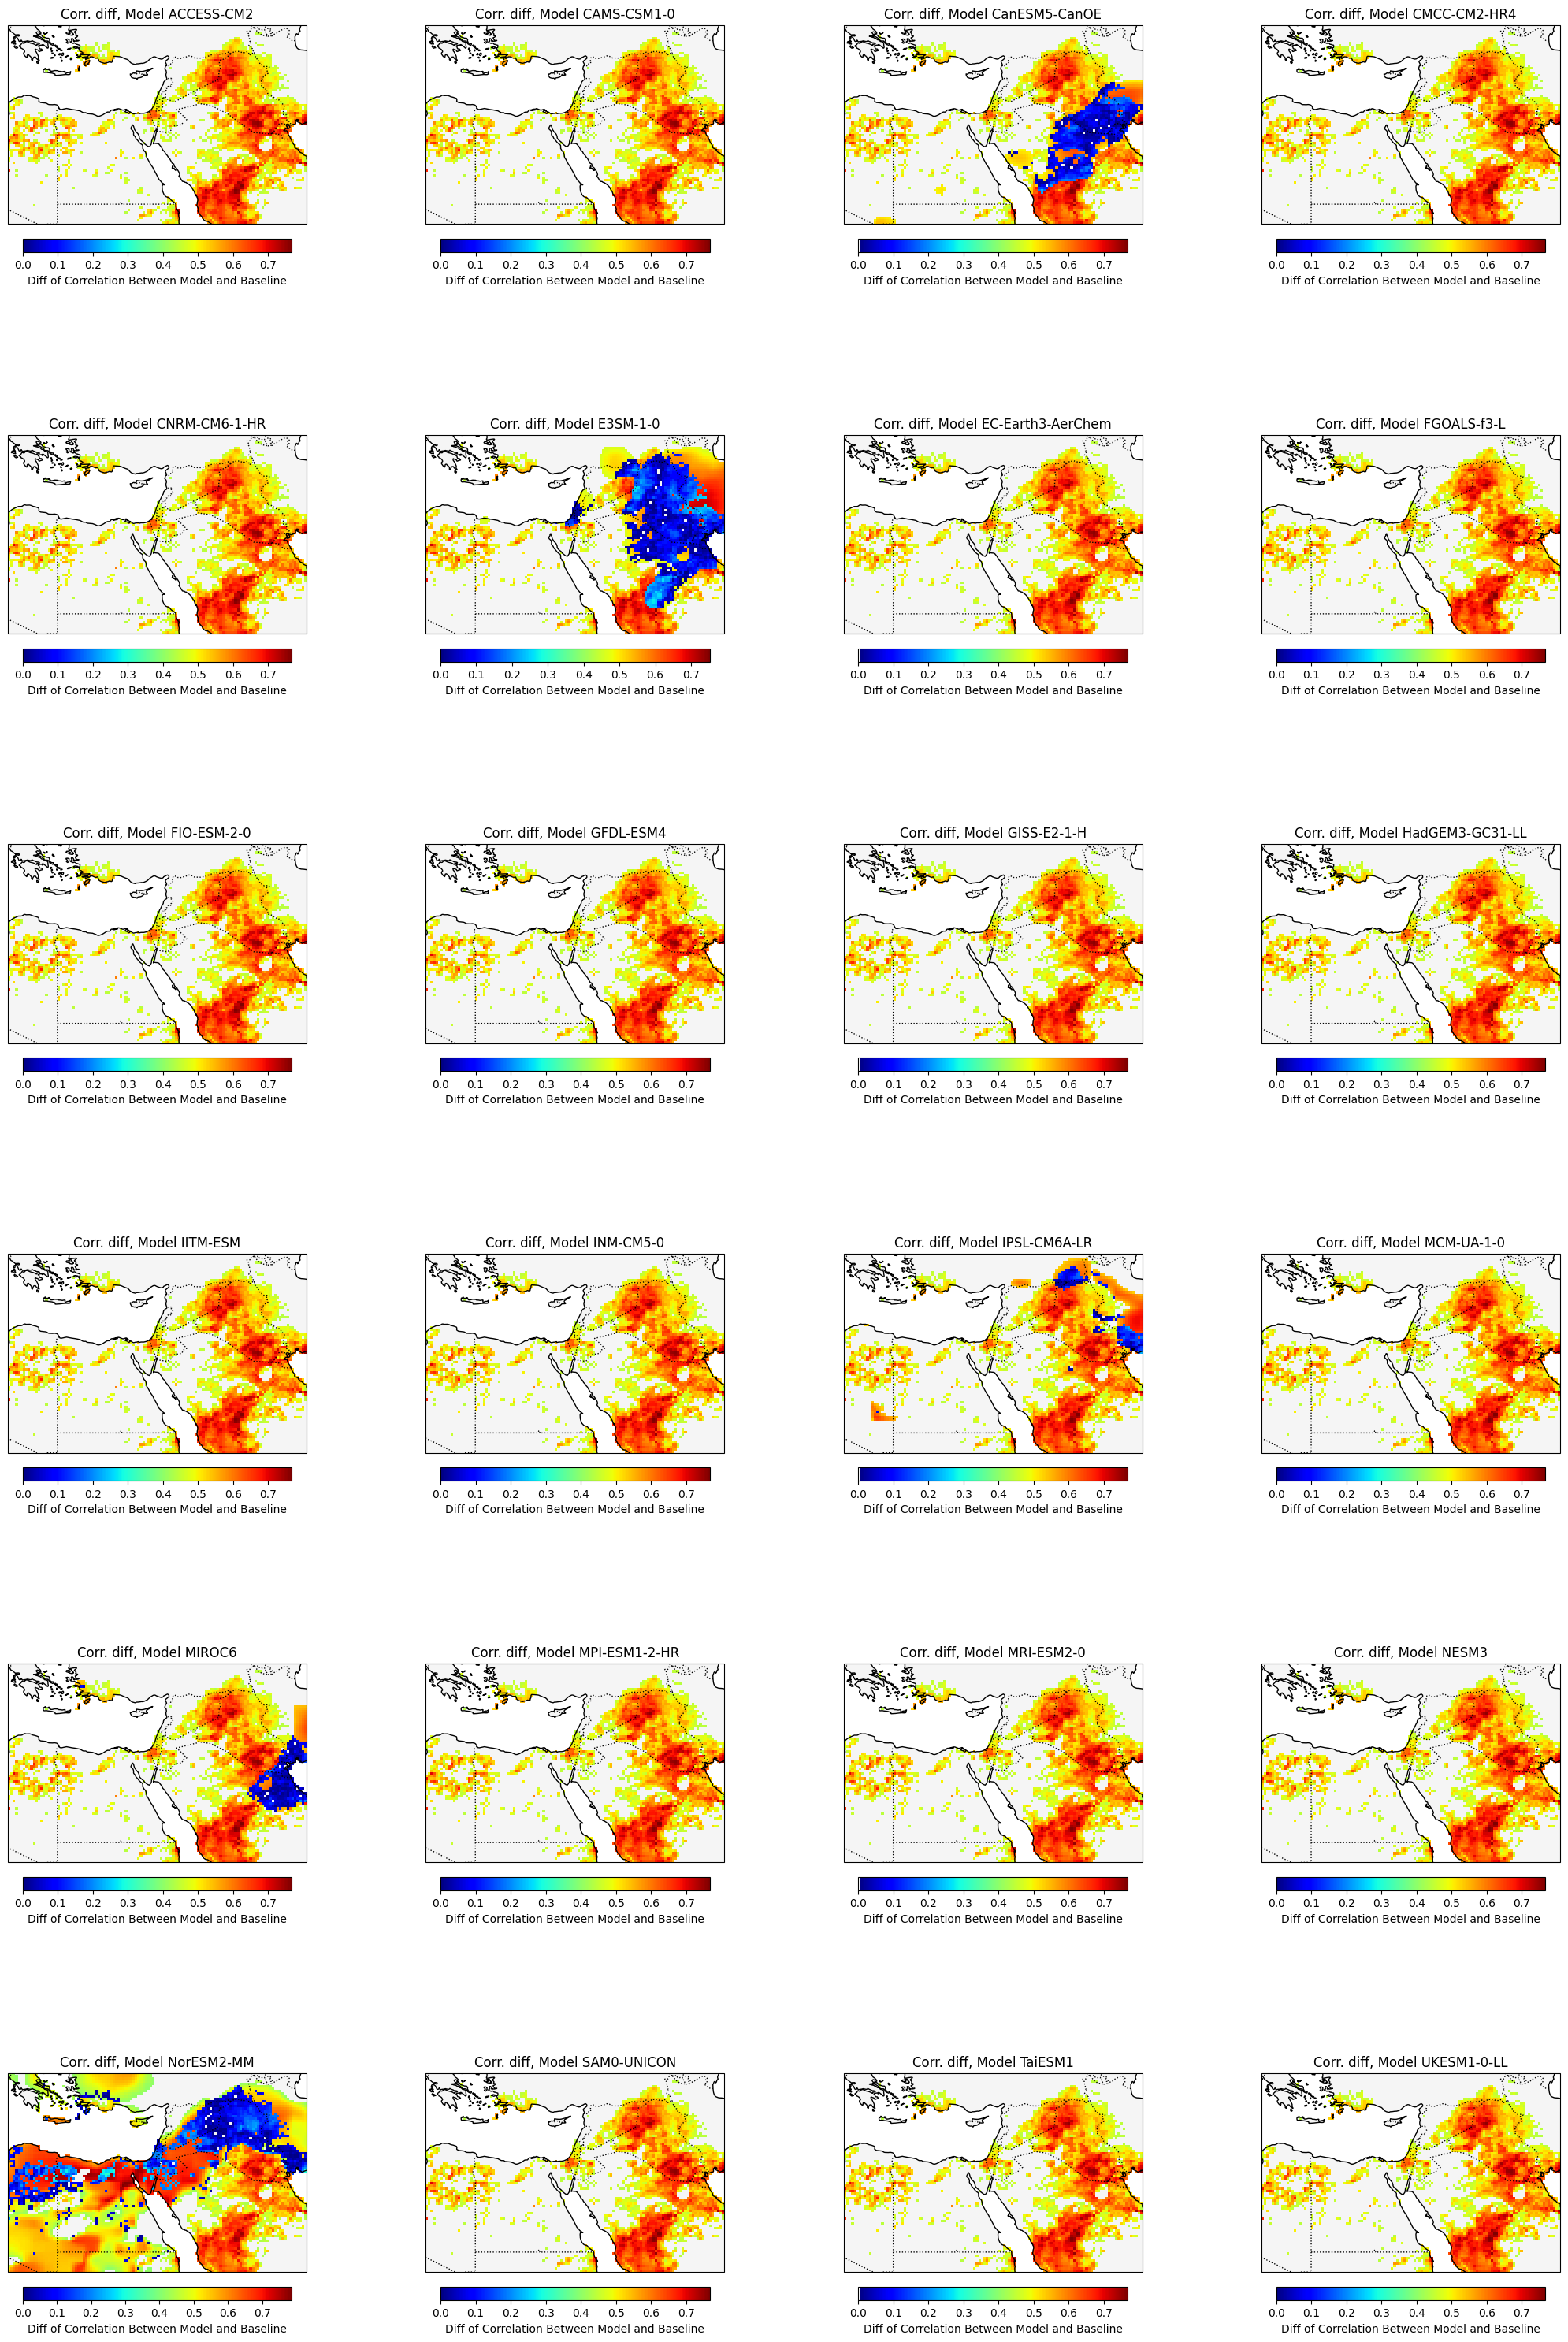

In [38]:
fig4, axes4 = plt.subplots(6, 4, figsize=(20, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig4.tight_layout()
mats = [np.abs(tested_corr_baseline_fdr - arr) for arr in list(corrected_corrs_fdr.values())]
titles = list(corrected_corrs_fdr.keys())

for i, (ax, key, value) in enumerate(zip(axes4.ravel(), titles, mats)):
    vis_helper.plot_precp_heatmap(ax, value, boundaries_middle_east, 'Diff of Correlation Between Model and Baseline', f'Corr. diff, Model {key}', 0)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

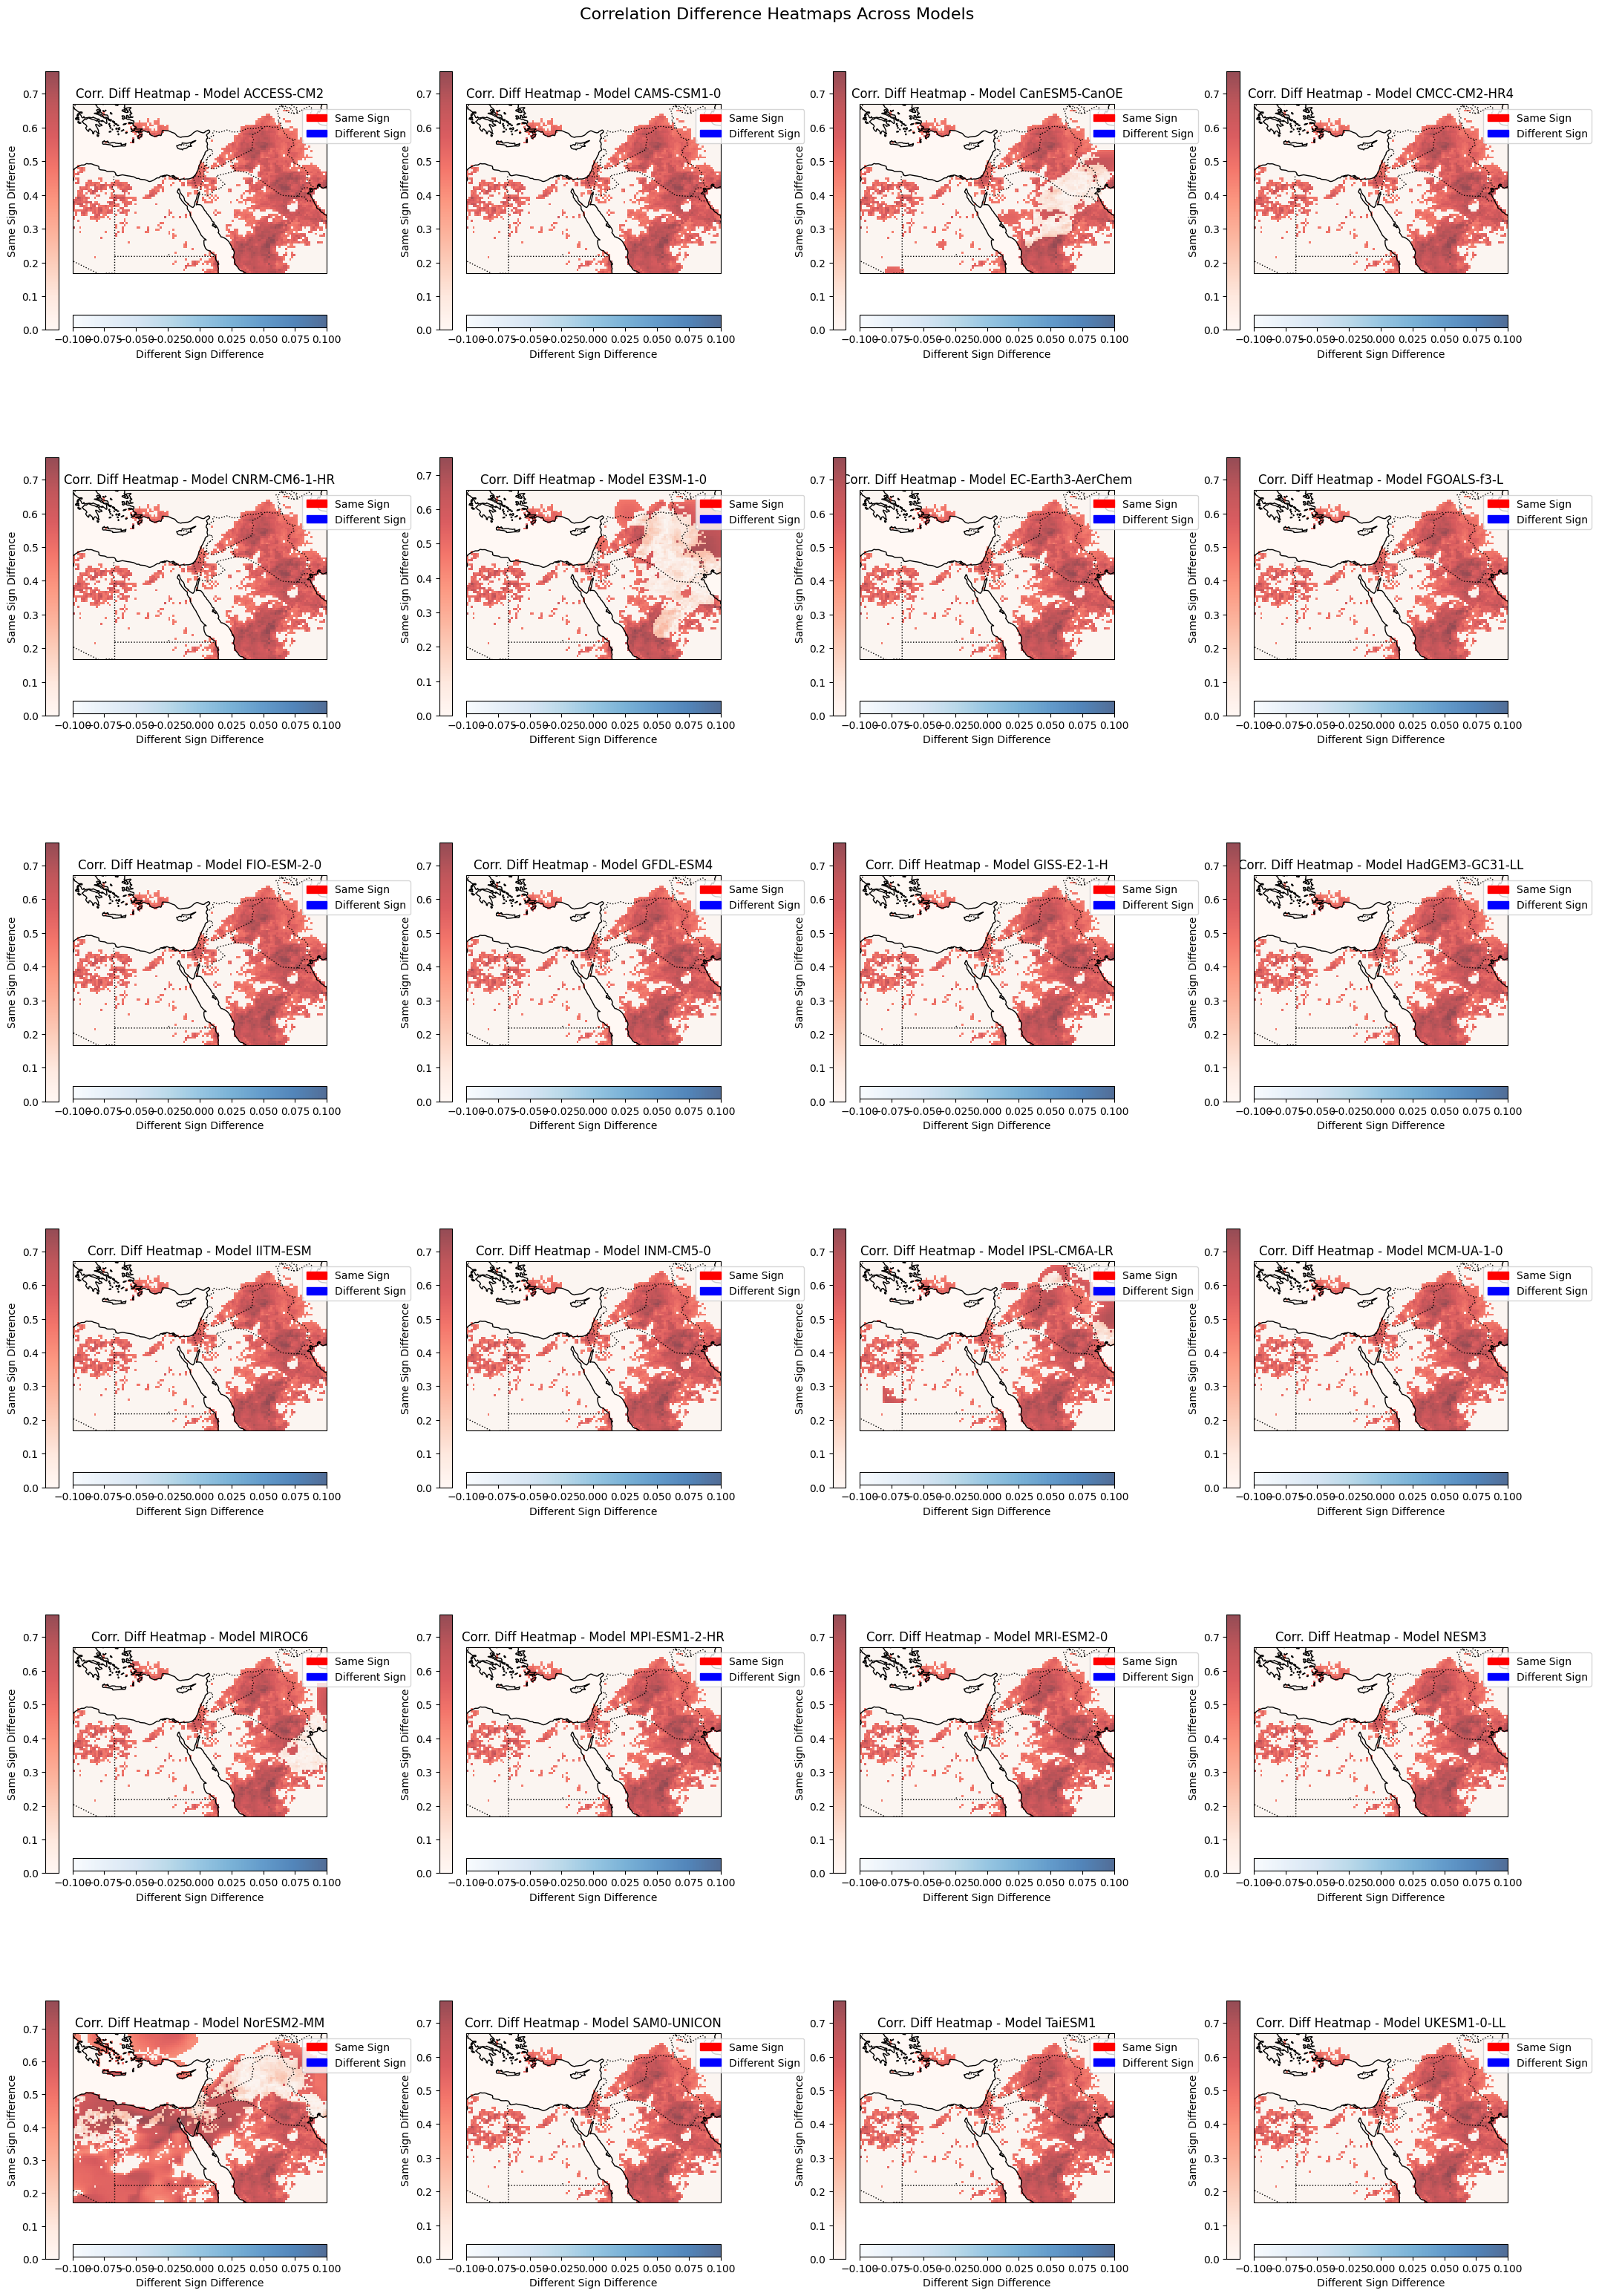

In [39]:
fig, axes = plt.subplots(6, 4, figsize=(20, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
mats, titles = helper.create_corr_diff_mats(tested_corr_baseline_fdr, corrected_corrs_fdr)

for i, (ax, key, value) in enumerate(zip(axes.ravel(), titles, mats)):
    vis_helper.plot_corr_diff(ax, value[0], value[1], boundaries_middle_east, label='Difference', title=f'Corr. Diff Heatmap - Model {key}')

fig.suptitle('Correlation Difference Heatmaps Across Models', fontsize=16, y=1.02)    
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [40]:
selected_models = ['NorESM2-MM', 'CNRM-CM6-1-HR', 'MCM-UA-1-0']


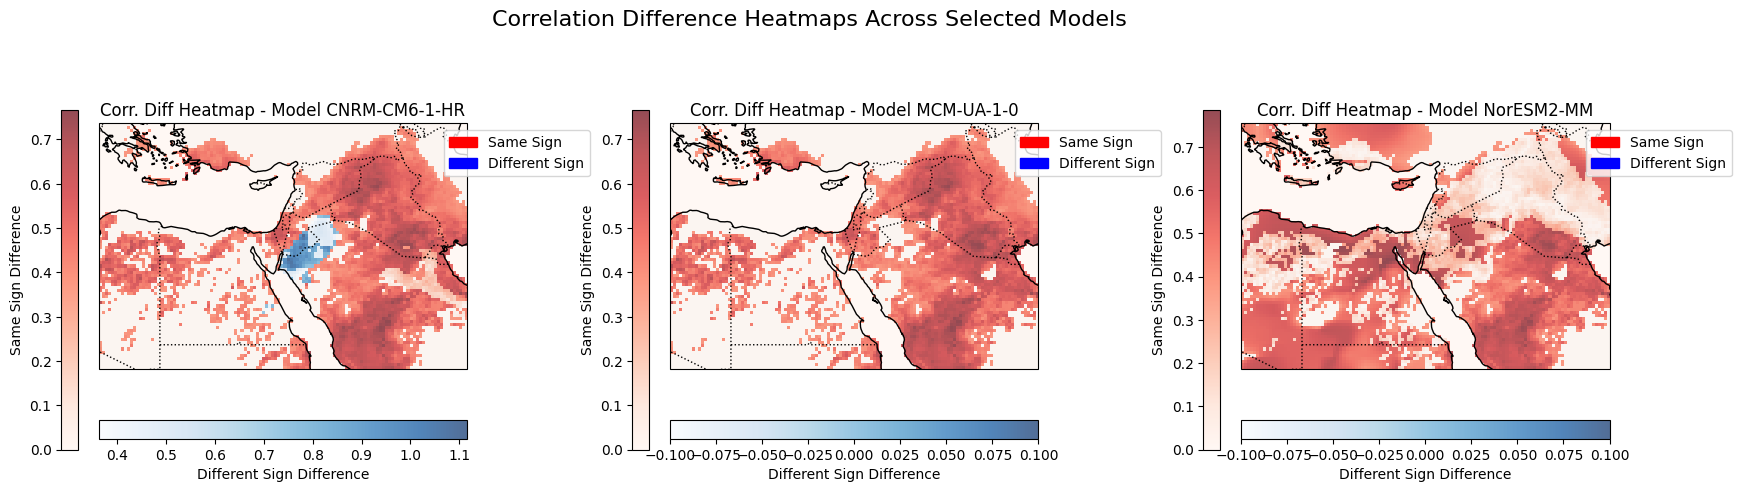

In [41]:
# Create correlation difference matrices and titles
mats, titles = helper.create_corr_diff_mats(tested_corr_baseline, tested_corrs)

# Filter the matrices and titles for the selected models
filtered_mats = [m for t, m in zip(titles, mats) if t in selected_models]
filtered_titles = [t for t in titles if t in selected_models]

# Create subplots for the selected models (3 in a single row)
fig, axes = plt.subplots(1, 3, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot each selected model
for ax, key, value in zip(axes, filtered_titles, filtered_mats):
    vis_helper.plot_corr_diff(ax, value[0], value[1], boundaries_middle_east, label='Difference', title=f'Corr. Diff Heatmap - Model {key}')

# Set the overall title and adjust layout
fig.suptitle('Correlation Difference Heatmaps Across Selected Models', fontsize=16, y=0.55)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, top=0.45)

# Show the plot
plt.show()

# DMI POS/NEG Effect on Precipitation

In the next part we will check if Positive DMI actually creates more rainfall.
We will begin by marking each DMI year as either positive or negative.

In [42]:
dmi_pos_neg = {key: np.where(dmi_arr >= 0, True, False) for key, dmi_arr in dmi.items()}

In [43]:
precip_diff_dmi = dict()
for key in tqdm.tqdm(masked_precip.keys()):
    diff_mat = helper.calc_iod_precp_effect(dmi_pos_neg[key], masked_precip[key])
    precip_diff_dmi[key] = diff_mat

  0%|                                                                                            | 0/24 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (17,80,120) (13,80,120) 

In [ ]:
diff_range_precip = vis_helper.get_diff_range(precip_diff_dmi)

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
mats = list(precip_diff_dmi.values())
titles = list(precip_diff_dmi.keys())

for i, (ax, key, value) in enumerate(zip(axes.ravel(), titles, mats)):
    vis_helper.plot_diff_heatmap(ax, value, boundaries_middle_east, 'Average Precipitation (mm/month) Diff', f'Positive - Negative DMI Effect Diff - {key}', diff_range_precip)

fig.suptitle('Average Precipitation Differences by DMI Effect', fontsize=16, y=1.02)   
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
filtered_matrices = {k: v for k, v in precip_diff_dmi.items() if k in selected_models}

fig, axes = plt.subplots(1, 3, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()}, sharey=False)

for ax, (key, value) in zip(axes, filtered_matrices.items()):
    vis_helper.plot_diff_heatmap(ax, value, boundaries_middle_east, 'Average Precipitation (mm/month) Diff', f'Positive - Negative DMI Effect Diff - {key}', diff_range_precip)

fig.suptitle('Average Precipitation Differences by DMI Effect for Chosen Models', fontsize=16, y=0.55)   
plt.subplots_adjust(wspace=0.4, top=0.45)
plt.show()

In [ ]:
dmi_pos_neg_baseline = np.where(dmi_baseline >= 0, True, False)
precip_diff_dmi_baseline = helper.calc_iod_precp_effect(dmi_pos_neg_baseline, precip_baseline)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vis_helper.plot_diff_heatmap(ax, precip_diff_dmi_baseline, boundaries_middle_east, 'Average Precipitation (mm/month) Diff', f'Positive - Negative DMI Effect on Precipitation Diff - Baseline', diff_range_precip)

# DMI POS/NEG Effect on MSLP & GPH 500 

In [ ]:
slp = helper.collect_all_datasets(SLP_path, 'slp')
gph = helper.collect_all_datasets(GPH500_path, 'gph500')

In [ ]:
optionsinterp = {"interpolate": True,
           "force grid": False,
           "average": False}

options = {"interpolate": False,
           "force grid": False,
           "average": False}

In [ ]:
slp = helper.slp_process(slp, target_dim=era5_dim, bounds_lat=bounds_general_lat, bounds_lon=bounds_general_lon, options=optionsinterp)
gph = helper.gph_process(gph, target_dim=era5_dim, bounds_lat=bounds_general_lat, bounds_lon=bounds_general_lon, options=optionsinterp)

In [ ]:
slp_effect = dict()
for key in tqdm.tqdm(slp.keys()):
    diff_mat = helper.calc_iod_slp_effect(dmi_pos_neg[key], slp[key])
    slp_effect[key] = diff_mat

In [ ]:
slp_effect_baseline = helper.calc_iod_slp_effect(dmi_pos_neg_baseline, mslp_baseline)

In [ ]:
diff_range_slp = vis_helper.get_diff_range(slp_effect)

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
mats = list(slp_effect.values())
titles = list(slp_effect.keys())

for i, (ax, key, value) in enumerate(zip(axes.ravel(), titles, mats)):
    vis_helper.plot_diff_heatmap(ax, value, boundaries_general, 'MSLP (hPa) Diff', f'Pos - Neg DMI MSLP Effect Diff - {key}', diff_range_slp)

fig.suptitle('MSLP Differences by DMI Effect', fontsize=16, y=1.02)       
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
filtered_matrices = {k: v for k, v in slp_effect.items() if k in selected_models}

fig, axes = plt.subplots(1, 3, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()}, sharey=False)

for ax, (key, value) in zip(axes, filtered_matrices.items()):
    vis_helper.plot_diff_heatmap(ax, value, boundaries_general, 'MSLP (hPa) Diff', f'Pos - Neg DMI MSLP Effect Diff - {key}', diff_range_slp)

fig.suptitle('MSLP Differences by DMI Effect for Chosen Models', fontsize=16, y=0.55)   
plt.subplots_adjust(wspace=0.4, top=0.45)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vis_helper.plot_diff_heatmap(ax, slp_effect_baseline, boundaries_general, 'MSLP (hPa) Diff', f'Pos - Neg DMI MSLP Effect Diff - Baseline', diff_range_slp)

In [ ]:
gph_effect = dict()
for key in tqdm.tqdm(gph.keys()):
    diff_mat = helper.calc_iod_gph_effect(dmi_pos_neg[key], gph[key])
    gph_effect[key] = diff_mat

In [ ]:
gph_effect

In [ ]:
gph_effect_baseline = helper.calc_iod_gph_effect(dmi_pos_neg_baseline, gph500_baseline)

In [ ]:
diff_range_gph = vis_helper.get_diff_range(gph_effect)

In [ ]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
fig.tight_layout()
mats = list(gph_effect.values())
titles = list(gph_effect.keys())

for i, (ax, key, value) in enumerate(zip(axes.ravel(), titles, mats)):
    vis_helper.plot_diff_heatmap(ax, value, boundaries_general, 'Z500(m) Diff', f'Pos - Neg DMI Z500 Effect Diff - {key}', diff_range_gph)

fig.suptitle('Z500 Differences by DMI Effect', fontsize=16, y=1.02)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
filtered_matrices = {k: v for k, v in gph_effect.items() if k in selected_models}

fig, axes = plt.subplots(1, 3, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()}, sharey=False)

for ax, (key, value) in zip(axes, filtered_matrices.items()):
    vis_helper.plot_diff_heatmap(ax, value, boundaries_general, 'Z500(m) Diff', f'Pos - Neg DMI Z500 Effect Diff - {key}', diff_range_gph)

fig.suptitle('Z500 Differences by DMI Effect for Chosen Models', fontsize=16, y=0.55)   
plt.subplots_adjust(wspace=0.4, top=0.45)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
vis_helper.plot_diff_heatmap(ax, gph_effect_baseline, boundaries_general, 'Z500(m) Diff', f'Pos - Neg DMI Z500 Effect Diff - Baseline', diff_range_gph)

# SAL Scores

First, lets look at the sal scores for the correlations

In [ ]:
domain_middle_east = np.where(np.isnan(tested_corr_baseline.data), 0, 1)
domain_general = np.ones(era5_dim)

In [ ]:
sal_scores_corr = dict()
for key, value in corrected_corrs_fdr.items():
    scores = helper.compute_SAL(value, tested_corr_baseline_fdr, domain_middle_east) # pysteps.verification.salscores.sal(value, tested_corr_baseline, thr_factor=1/15) # TODO - examine threshold choice
    sal_scores_corr[key] = scores
    print(f'{key} - {scores}')

In [ ]:
import seaborn as sns
def create_SAL_table(sal_scores):
    res = pd.DataFrame(sal_scores, index=["S", "A", "L"]).T
    res.sort_index(inplace=True)
    plt.figure(figsize=(8,12))
    plt.title("SAL Scores Results - Correlation Data")
    ax = sns.heatmap(res, annot=True, cmap='coolwarm', vmin=-2, vmax=2, center=0)
    ax.xaxis.tick_top()
    plt.show()

In [ ]:
vis_helper.plot_SAL(sal_scores_corr,'Model SAL Scores Visualization for Correlation Data')

Now we would like to look at the SAL scores for the other graphs we created - DMI effect on MSLP, GPH 500 and POS/NEG precipitation, as well as overall precipitation. First, lets retrieve the precipitation data, this time averaged.

In [ ]:
options = {"interpolate": True,
           "force grid": False,
           "average": True}
precip_data  = helper.collect_all_datasets(precipitation_path, 'precip', chirps_dim, unit_conversion, bounds_middle_east_lat, bounds_middle_east_lon, options)

Next, lets see our results for each type of graph.

In [ ]:
precip_data_for_sal = {}
for key, value in precip_data.items():
    precip_data_for_sal[key] = value[0]

In [ ]:
sal_scores_precip = {}
sal_scores_pos_neg = {}
sal_scores_mslp = {}
sal_scores_gph500 = {}
domains = [domain_middle_east, domain_middle_east, domain_general, domain_general]
baselines = [np.mean(precip_baseline, axis=0), precip_diff_dmi_baseline, slp_effect_baseline, gph_effect_baseline]
sal_scores = [sal_scores_precip, sal_scores_pos_neg, sal_scores_mslp, sal_scores_gph500]
names = ['Precipitation', 'DMI effect on Precipitation', 'DMI effect on MSLP', 'DMI effect on Z500']
sal_data = [precip_data_for_sal, precip_diff_dmi, slp_effect, gph_effect]

In [ ]:
slp_effect['ACCESS-CM2'].shape

In [ ]:
for i in range(len(sal_data)):
    print(i)
    for key, value in sal_data[i].items():
        scores = helper.compute_SAL(value, baselines[i], domains[i]) # pysteps.verification.salscores.sal(value, tested_corr_baseline, thr_factor=1/15) # TODO - examine threshold choice
        sal_scores[i][key] = scores

Now lets see the results:

In [ ]:
for i, scores in enumerate(sal_scores):
    vis_helper.plot_SAL(scores,f'Model SAL Scores Visualization for {names[i]} Data')

Finally, we want to visualize the results in a compact table. We would look both at the averaged component of each model, and at a breakdown of each model over all 5 different SAL breakdowns

In [ ]:
sal_scores = [sal_scores_corr, sal_scores_precip, sal_scores_pos_neg, sal_scores_mslp, sal_scores_gph500]

In [ ]:
averaged_sal_scores = {}
for key, value in sal_scores[0].items():
#     try:
    s = np.nanmean([np.abs(sal_scores[i][key][0] if not np.isnan(sal_scores[i][key][0]) else 2) for i in range(len(sal_scores)) if key in sal_scores[i]])
    a = np.nanmean([np.abs(sal_scores[i][key][1] if not np.isnan(sal_scores[i][key][1]) else 2) for i in range(len(sal_scores)) if key in sal_scores[i]])
    l = np.nanmean([np.abs(sal_scores[i][key][2] if not np.isnan(sal_scores[i][key][2]) else 2) for i in range(len(sal_scores)) if key in sal_scores[i]])
#     except KeyError ke:
    averaged_sal_scores[key] = (s, a, l)

In [ ]:
vis_helper.create_agg_SAL_table(averaged_sal_scores)

In [ ]:
vis_helper.create_verbose_SAL_table(sal_scores[0], sal_scores[1], sal_scores[2], sal_scores[3], sal_scores[4])
# needs some fixes in the upper ticks

Finally, lets use our knowledge to rank the models. For each model we will calculate its averegae SAL score's euclidian distance from 0 (which represents a perfect match for all metrics), and present our data accordingly. 

In [ ]:
np.zeros(3)

In [ ]:
for key, val in averaged_sal_scores.items():
    print(np.array(val), np.zeros(len(val)))

In [ ]:
ranked_sal = {model: np.linalg.norm(np.array(scores)) for model, scores in averaged_sal_scores.items()}
ranked_df = pd.DataFrame(ranked_sal, index=['Rank']).T
ranked_df.sort_values('Rank', inplace=True)
ranked_df

In [ ]:
def make_pretty_avg(styler):
    styler.set_caption("Ranked Models by SAL Scores")

    styler.background_gradient(axis=None, vmin=-2, vmax=2, cmap="coolwarm")
    return styler

In [ ]:
ranked_df.style.pipe(make_pretty_avg)

In [ ]:
ranked_sal_corrs = {model: np.linalg.norm(np.array(scores)) for model, scores in sal_scores_corr.items()}
ranked_df_corr = pd.DataFrame(ranked_sal_corrs, index=['Rank']).T
ranked_df_corr.sort_values('Rank', inplace=True)
ranked_df_corr

In [ ]:
def make_pretty_corr(styler):
    styler.set_caption("Ranked Models by SAL Scores")
    styler.background_gradient(axis=None, vmin=-2, vmax=2, cmap="coolwarm")
    return styler

In [ ]:
ranked_df_corr.style.pipe(make_pretty_corr)

In [ ]:
def create_SAL_table(sal_scores):
    res = pd.DataFrame(sal_scores, index=["S", "A", "L"]).T
    res.sort_index(inplace=True)
    plt.figure(figsize=(8,12))
    plt.title("SAL Scores Results - Averaged Scores")
    ax = sns.heatmap(res, annot=True, cmap='coolwarm', vmin=-2, vmax=2, center=0)
    ax.xaxis.tick_top()
    plt.show()

In [ ]:
create_SAL_table(sal_scores[0])

In [ ]:
sal_scores_all = {}
for scores in sal_scores:
    for model, scores in scores.items():
        if model in sal_scores_all:
            sal_scores_all[model].extend([val for val in scores if not np.isnan(val)])
        else:
            sal_scores_all[model] = [val for val in scores if not np.isnan(val)]

In [ ]:
sal_scores_all

In [ ]:
ranked_sal_all = {model: np.linalg.norm(np.array(scores)) for model, scores in sal_scores_all.items()}
ranked_df_all = pd.DataFrame(ranked_sal_all, index=['Rank']).T
ranked_df_all.sort_values('Rank', inplace=True)
ranked_df_all

In [ ]:
def make_pretty_all(styler):
    styler.set_caption("Ranked Models by SAL Scores")
    styler.background_gradient(axis=None, vmin=0, vmax=6, cmap="coolwarm")
    return styler

In [ ]:
ranked_df_all.style.pipe(make_pretty_all)

In [ ]:
(nc.Dataset(f"{ERA5_path}/MSLP_ERA5.nc")).variables['msl'][:] / 100

In [ ]:
A = helper.collect_all_datasets(SLP_path, 'slp')

In [ ]:
A['ACCESS-CM2']['psl']